In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("ggplot")
from ipywidgets import interact
import numpy as np
import matplotlib as mpl
import arrow
%matplotlib inline

In [22]:
#############################################################################
# Prepare data and import into a dataframe
#############################################################################

# Export Data from healthkit using [qs-access](https://itunes.apple.com/us/app/qs-access/id920297614?mt=8) app 
exported_and_trandformed_csv_file = "data/weight.csv"
df = pd.read_csv(exported_and_trandformed_csv_file)

idx_weight = "Weight (kg)"
# make dateColumn a datetime.
idx_date="Start"
df[idx_date] = pd.to_datetime(df[idx_date])
df = df.set_index(df[idx_date])
# Create Time Period Groups
idx_month_year="month_year" 
df[idx_month_year]=df[idx_date].apply(lambda t:f"{t.month}-{t.year-2000}")

idx_week_year="week_year" 
df[idx_week_year]=df[idx_date].apply(lambda t:f"{t.week}-{t.year-2000}")

# Data cleaning 
###########################

# Remove 0 weight values.
df = df.replace(0,np.nan)
# Throw away junk data at the start of time
df = df['2010/1/1':] 
# KG to lbs
df[idx_weight] = df[idx_weight] *2.2


# Helpful time aliases
df_alltime = df

In [23]:
def plot_weight_over_time(df, x):
    # In theory can use plot.ly (not free)  or Bokeh (not mpl compatible) but issues. So setting dimensions old school.
    # Manually setting the weight and width. 
    height_in_inches=8
    mpl.rc("figure", figsize=(2*height_in_inches,height_in_inches))
 
    ax = sns.boxplot(x=x, y=idx_weight, data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    # ax.set_title("Weight")
    ax.set_xlabel("date")
    ax.set_ylabel("lbs")

# Recent Weight By Weeks

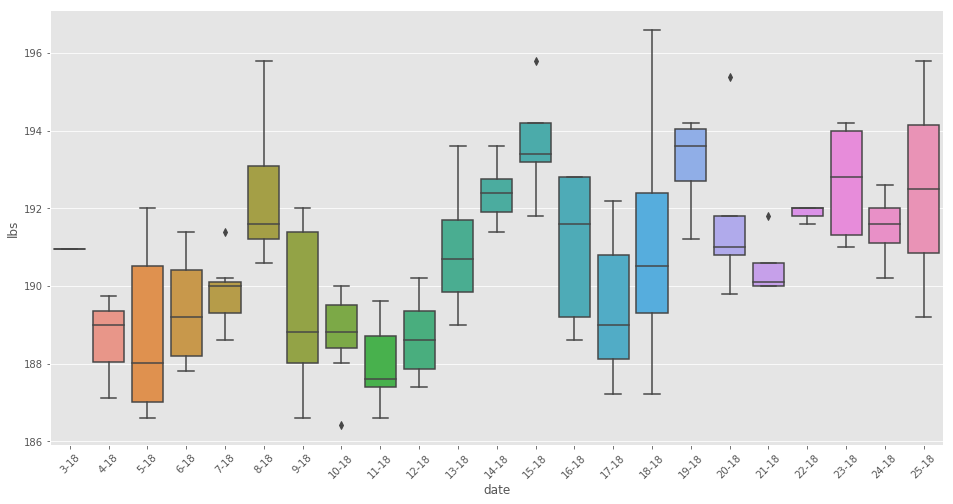

In [24]:
earliest = arrow.utcnow().shift(months=-5).date()
df_recent = df[df[idx_date] > earliest ]
plot_weight_over_time(df_recent,idx_week_year)

# Historical Weight By Month

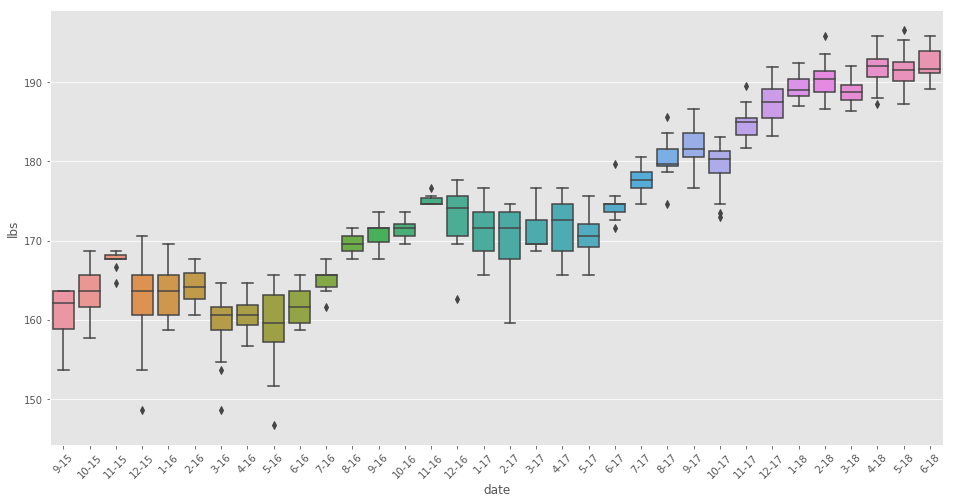

In [25]:
plot_weight_over_time(df_alltime,idx_month_year)

# Time Series Analysis Methodology using resampling

In [ ]:
tempFrame = df.resample("W").apply([ len,np.min,np.median,np.max])
tempFrame.sort_index(ascending=False ).head(15)
# Can graph interactively using Bokeh @ 
# https://stackoverflow.com/questions/45972782/plot-time-series-graph-using-bokeh